In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


In [2]:
train = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Train_Dataset.csv")
test = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Test_Dataset.csv")
val = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Val_Dataset.csv")
print(train)
print(test)
print(val)

                                                    text    label
0      On days when I feel close to my partner and ot...      joy
1      Every time I imagine that someone I love or I ...     fear
2      When I had been obviously unjustly treated and...    anger
3      When I think about the short time that we live...  sadness
4      After my girlfriend had taken her exam we went...      joy
...                                                  ...      ...
22478  i am feeling damned much like a the guy seen i...        5
22479  i am suddenly feeling much like quite the guy ...        5
22480  guys i need today to do this that week and the...        5
22481  i need therapy to do this that and the two oth...        5
22482  but i need to do this that and the other for c...        5

[22483 rows x 2 columns]
                                                   text    label
0                 South Korea cheating for gold medals.    anger
1     My friend has to go on field trips, he just to

In [3]:
def get_tweet(data):
    tweets = data['text']
    labels = data['label']
    labels = labels.replace(["0","1","2","3","4","5"],['sadness','joy','love','anger','fear','surprise'])
    return tweets, labels

In [4]:
tweets, labels = get_tweet(train)

In [5]:
print(labels)

0             joy
1            fear
2           anger
3         sadness
4             joy
           ...   
22478    surprise
22479    surprise
22480    surprise
22481    surprise
22482    surprise
Name: label, Length: 22483, dtype: object


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [7]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [8]:
tokenizer.texts_to_sequences([tweets[1]])

[[177, 46, 2, 982, 10, 143, 2, 84, 39, 2, 80, 1305, 7, 1097, 1306, 72, 397]]

In [9]:
tweets[1]

'Every time I imagine that someone I love or I could contact a serious illness, even death.'

<function matplotlib.pyplot.show(close=None, block=None)>

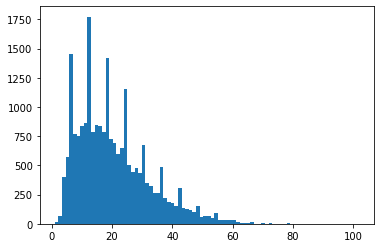

In [10]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show

In [11]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post' , padding='post', maxlen = maxlen)
  return padded

In [13]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [14]:
padded_train_seq

array([[  30,  163,   18, ...,    0,    0,    0],
       [ 177,   46,    2, ...,    0,    0,    0],
       [  18,    2,   34, ...,    0,    0,    0],
       ...,
       [ 637,    2,  128, ...,  115,   21,    2],
       [   2,  128, 2241, ...,    2,   63,   24],
       [  21,    2,  128, ...,   63,   24,   10]])

In [15]:
classes = set(labels)
print(classes)

{'sadness', 'love', 'anger', 'fear', 'surprise', 'joy'}


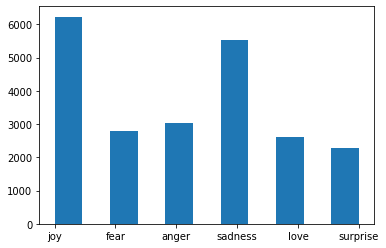

In [16]:
plt.hist(labels, bins=11)
plt.show()

In [17]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [18]:
class_to_index

{'sadness': 0, 'love': 1, 'anger': 2, 'fear': 3, 'surprise': 4, 'joy': 5}

In [19]:
index_to_class

{0: 'sadness', 1: 'love', 2: 'anger', 3: 'fear', 4: 'surprise', 5: 'joy'}

In [20]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [21]:
train_labels = names_to_ids(labels)
print(train_labels[0])

5


In [22]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [24]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [25]:
val_tweets[0], val_labels[0]

('The news of the natural calamity, an earthquake in which hundreds of Mexican people died.',
 0)

In [26]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
703/703 [==============================] - 24s 18ms/step - loss: 1.3478 - accuracy: 0.4092 - val_loss: 0.9992 - val_accuracy: 0.6055
Epoch 2/20
703/703 [==============================] - 11s 16ms/step - loss: 0.6777 - accuracy: 0.7499 - val_loss: 0.6066 - val_accuracy: 0.8066
Epoch 3/20
703/703 [==============================] - 11s 16ms/step - loss: 0.3741 - accuracy: 0.8767 - val_loss: 0.4950 - val_accuracy: 0.8416
Epoch 4/20
703/703 [==============================] - 11s 16ms/step - loss: 0.2313 - accuracy: 0.9270 - val_loss: 0.5299 - val_accuracy: 0.8371
Epoch 5/20
703/703 [==============================] - 12s 18ms/step - loss: 0.1768 - accuracy: 0.9447 - val_loss: 0.4741 - val_accuracy: 0.8532
Epoch 6/20
703/703 [==============================] - 12s 16ms/step - loss: 0.1306 - accuracy: 0.9595 - val_loss: 0.5209 - val_accuracy: 0.8514
Epoch 7/20
703/703 [==============================] - 11s 16ms/step - loss: 0.1097 - accuracy: 0.9659 - val_loss: 0.5558 - val_accuracy:

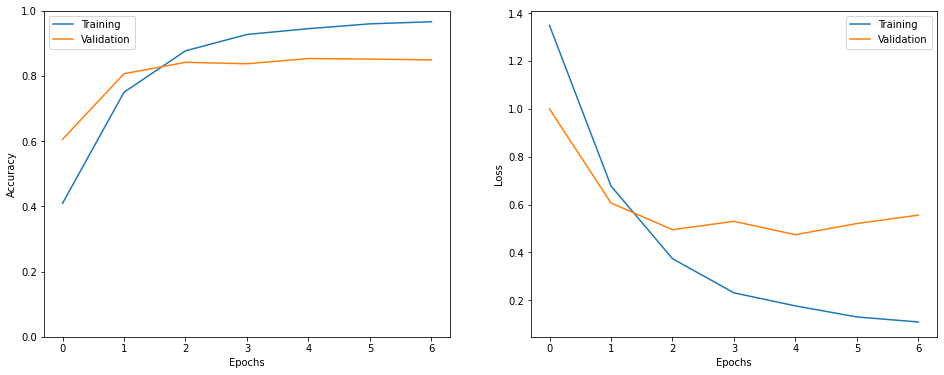

In [27]:
show_history(h)

In [28]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [29]:
_=model.evaluate(test_seq, test_labels)

88/88 [==============================] - 1s 6ms/step - loss: 0.6815 - accuracy: 0.8086


In [52]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: usually i just keep on that feeling blessed
Emotion: love
Predicted Emotion: love


In [31]:
preds = np.argmax(model.predict(test_seq), axis=-1)

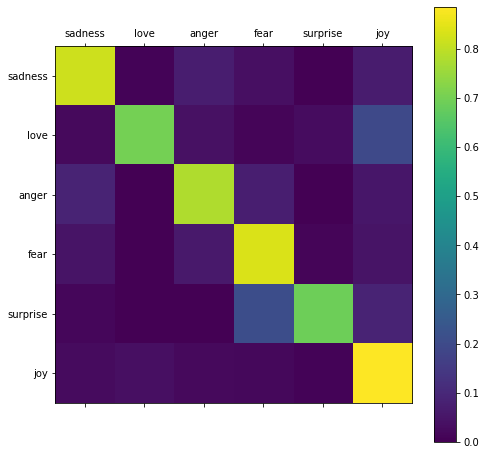

In [32]:
show_confusion_matrix(test_labels, preds, list(classes))

In [51]:
from datetime import datetime
model.save("C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Python Scripts/SA_Model_Final_{}".format(datetime.now().strftime("%d%m%Y_%H_%M_%S")))

INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Python Scripts/SA_Model_Final_01012022_20_34_40\assets


INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Python Scripts/SA_Model_Final_01012022_20_34_40\assets


In [39]:
datetime.now().strftime("%d%m%Y_%H:%M:%S")

'01012022_20:24:17'

In [44]:
.format(datetime.now().strftime("%d%m%Y_%H:%M:%S"))

SyntaxError: invalid syntax (Temp/ipykernel_13948/1529566601.py, line 1)